## 1. Setup and Load Data

1.1 installing dependencies and load data

In [1]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = '/content/ezyzip.zip'

# Specify the directory to extract the contents
extracted_dir = '/content/data'

# Create the target directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# List the contents of the extracted directory
extracted_files = os.listdir(extracted_dir)
print("Contents of the extracted directory:", extracted_files)


Contents of the extracted directory: ['data']


In [2]:
!pip install tensorflow  opencv-python matplotlib

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

1.2 Remove Dodgy image

In [5]:
import cv2
import imghdr

In [6]:
data_dir = '/content/data/data'

In [7]:
os.listdir(data_dir)   #check the folder in the data directory  os.path.join this prints every singleimage inside each folder in the directory

['plastic', 'metal', 'litter', 'glass']

In [8]:
img_exts= ['jpeg','jbg','png','bmp']   # image extension

In [9]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img = cv2.imread(image_path)   # converting the image into opencv (is used to read an image from a file and store it as a NumPy array)
      tip = imghdr.what(image_path)
      if tip not in img_exts:
        print("Image not exist in list{}:".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print("Exception with image:".format(image_path))

      # so basically if the image is not the valid image and not the valid extension i.e. jpeg,png,bmp,jgb then we should get rid of that image


1.3 Load data

In [10]:
tf.data.Dataset??

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
tf.keras.utils.image_dataset_from_directory??

In [13]:
data = tf.keras.utils.image_dataset_from_directory('/content/data/data')

Found 6377 files belonging to 4 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
data_iterator

In [16]:
batch=data_iterator.next()

In [17]:
len(batch)

2

In [18]:
batch[0].shape

(32, 256, 256, 3)

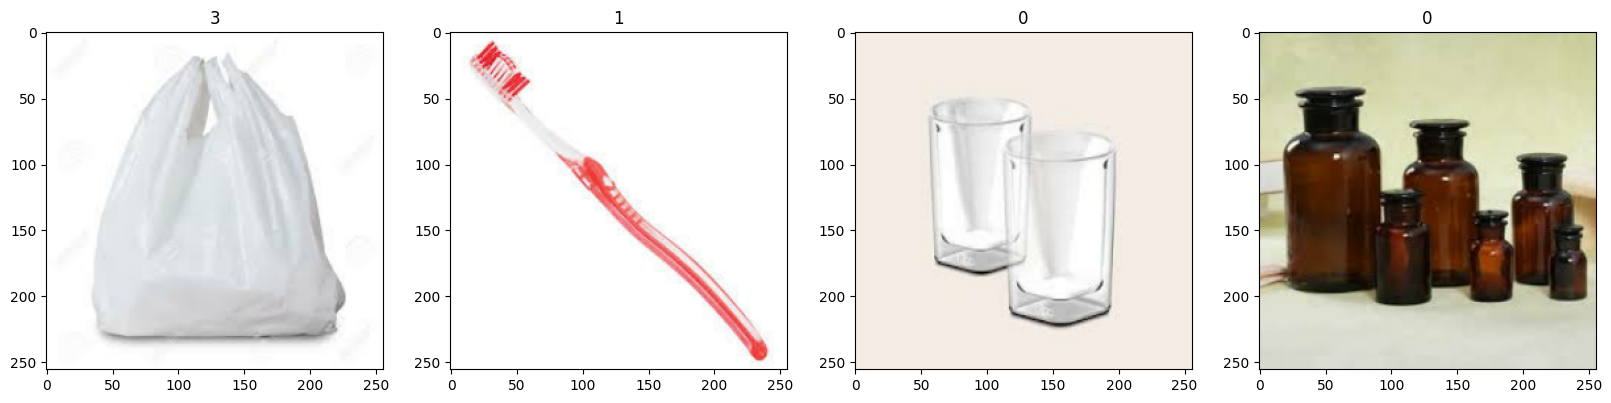

In [19]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

## 2.Preprocess the data

2.1 scale the data

In [20]:
data = data.map(lambda x,y:(x/255,y))

In [21]:
data.as_numpy_iterator().next()

(array([[[[0.7294118 , 0.9019608 , 0.90588236],
          [0.7294118 , 0.9019608 , 0.90588236],
          [0.7294118 , 0.9019608 , 0.90588236],
          ...,
          [0.7411765 , 0.87058824, 0.8901961 ],
          [0.7411765 , 0.87201285, 0.8909084 ],
          [0.7411765 , 0.8784314 , 0.89411765]],
 
         [[0.732621  , 0.90517   , 0.9090916 ],
          [0.732621  , 0.90517   , 0.9090916 ],
          [0.732621  , 0.90517   , 0.9090916 ],
          ...,
          [0.7411765 , 0.87058824, 0.8901961 ],
          [0.7411765 , 0.87201285, 0.8909084 ],
          [0.7411765 , 0.8784314 , 0.89411765]],
 
         [[0.73333335, 0.90588236, 0.9098039 ],
          [0.73333335, 0.90588236, 0.9098039 ],
          [0.73333335, 0.90588236, 0.9098039 ],
          ...,
          [0.7411765 , 0.87058824, 0.8901961 ],
          [0.7416731 , 0.87250954, 0.89140505],
          [0.74391085, 0.88116574, 0.896852  ]],
 
         ...,
 
         [[0.8850873 , 0.9658931 , 0.9607843 ],
          [0.88508

2.2 Split data

To introduce randomness we should shuffle the data before splitting it

In [22]:
len(data)

200

This means we have 200 batches where each batch consist of 32 images

In [23]:
data = data.shuffle(buffer_size=len(data), seed=42)

Approach 1

In [24]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [25]:
print(train_size)
print(val_size)
print(test_size)

140
40
20


Approach 2

In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [27]:
print(train_size)
print(val_size)
print(test_size)

140
40
20


## 3. Deep Model

3.1 building deep learning model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,MaxPooling2D,Conv2D

In [29]:
model=Sequential()

In [30]:
model.add(Conv2D(16,(3,3),1,activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [31]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

3.2 Train

In [33]:
logdir='/content/log'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist=model.fit(train,epochs=5,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/5
140/140 [==============================] - 44s 94ms/step - loss: -73718.9219 - accuracy: 0.4344 - val_loss: -651649.3750 - val_accuracy: 0.4289
Epoch 2/5
140/140 [==============================] - ETA: 0s - loss: -12071419.0000 - accuracy: 0.4315

3.3 plot performance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

## 4.Evaluate Performance

4.1 Evaluate

In [ ]:
from tensorflow.keras.metrics import Recall,Precision,BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  x,y = batch
  yhat = model.predict(x)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)

In [ ]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

In [ ]:
import cv2

In [ ]:
img=cv2.imread('/content/brown-glass15.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

In [ ]:
yhat